**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_img_lst = os.listdir("./train")
val_img_lst = os.listdir("./val")
test_img_lst = os.listdir("./test")
print(len(train_img_lst),len(val_img_lst), len(test_img_lst))

6 2 2


In [3]:
'''This function makes pairs of directories of Image and its mask '''
def make_pair(img_lst,image_dir,mask_dir):
    pairs = []
    #print(image_dir+img_lst[0])
    for im in img_lst:
        pairs.append((image_dir + im, mask_dir + im.split('.')[0]+'.png'))
    return pairs

In [4]:
'''Here we create lists of pairs of images and corresponding masks for both train and validation Images'''
train_pairs = make_pair(train_img_lst, "./train/", "./train_labels/")
val_pairs = make_pair(val_img_lst, "./val/", "./val_labels/")
test_pairs = make_pair(test_img_lst, "./test/", "./test_labels/")

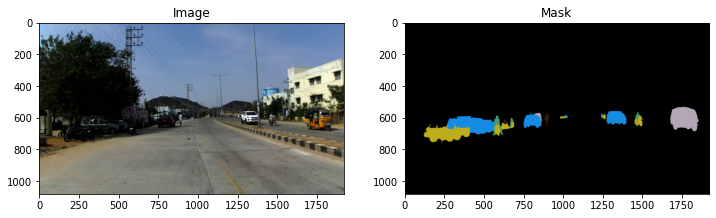

In [5]:
'''We can simply plot and see the image and corresponding mask from above list of directories randomly'''
temp = choice(train_pairs)
img = img_to_array(load_img(temp[0]))
mask = img_to_array(load_img(temp[1]))

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Image")
plt.imshow(img/255)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask/255)
plt.show()

**A CSV file of Class map is made, which gives us the colour mapping. We will load it and see how mapping works**

In [6]:
class_map_df = pd.read_csv("./class_dict.csv")
class_map_df

,name,r,g,b
0,Bus,62,70,189
1,Motorcycle,189,173,26
2,Car,22,139,228
3,Person,55,23,7
4,Truck,50,143,6
5,Autorickshaw,179,166,183
6,Rider,71,150,114
7,Void,0,0,0


**This class map csv file defines 8 different classes and their RGB values to be mapped. So, we convert it into List whose index will give Class and entry at that index gives RGB values of that class/index.**

In [7]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
print(len(class_map))
print(class_map[0])

8
[ 62  70 189]


In [8]:
"""This function will be used later, to assert that mask should contains values that are class labels only.
   Like, our example has 8 classes, so predicted mask must contains values between 0 to 7. 
   So that it can be mapped to corresponding RGB."""
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [9]:
'''This method will convert mask labels(to be trained) from RGB to a 2D image which holds class labels of the pixels.'''
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    return label

In [10]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([1, 2, 3, 5, 6, 7], dtype=uint8),
 array([  27930,   39258,    2029,   21902,    4963, 1977518], dtype=int64))

**This class is a custom datagenerator, which takes pairs list and return images and 2D labeled masks. We will use this generator to feed our model.**

In [11]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair,class_map,  batch_size=4, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            batch_labels.append(label)
        return np.array(batch_imgs), np.array(batch_labels)

**Creating objects of Class Datagenerator and trying to plot what it returns to validate its proper working.**

(4, 512, 512, 3) (4, 512, 512)
Images


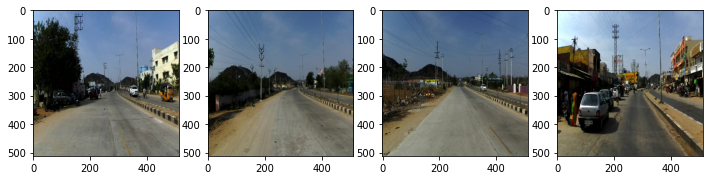

Masks


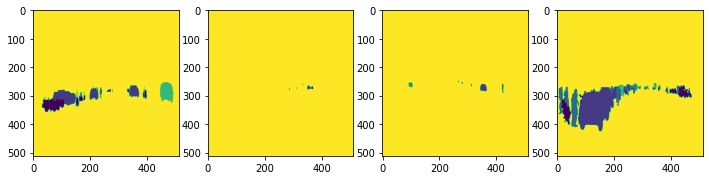

In [12]:
img_size = 512

train_generator1 = DataGenerator(train_pairs,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
X,y = train_generator1.__getitem__(0)
print(X.shape, y.shape)


plt.figure(figsize=(12, 6))
print("Images")
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(X[i])
plt.show()

print("Masks")
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(y[i])
plt.show()

**Go and uncomment those lines in Datagenerator class, __data_generation() method and run that cell again.**

In [13]:
train_generator = DataGenerator(train_pairs,class_map,batch_size=2, dim=(img_size,img_size,3) ,shuffle=True)
val_generator = DataGenerator(val_pairs, class_map, batch_size=2, dim=(img_size,img_size,3) ,shuffle=True)
test_generator = DataGenerator(test_pairs, class_map, batch_size=2, dim=(img_size,img_size,3) ,shuffle=True)

**U-Net Model**

In [14]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y
def Unet(h, w, filters, num_classes = 8):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [15]:
model = Unet(img_size , img_size , 8)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  224         ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
mc = ModelCheckpoint(mode='max', filepath='top-weights-na.h5', monitor='val_acc',save_best_only='True', verbose=1)
es = EarlyStopping(monitor='val_acc', patience=10, verbose=0)

**Train steps = train_size/batch_size | Val steps = validation_size/batch_size**

In [18]:
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()

print(train_steps, val_steps)

3 1


**I trained the model and saved it and loaded again to evaluate. Here I do not train the model fully again but run it for a single epoch, as I have already trained it on a GPU**

In [19]:
results = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=1,
                              validation_data=val_generator, validation_steps=val_steps, callbacks=[mc,es],
                              verbose = 1)

3/3 [==============================] - 20s 4s/step - loss: 2.4624 - accuracy: 0.0041 - val_loss: 2.1003 - val_accuracy: 0.0085


In [20]:
model.save('./MODELS/idd_unet_model_na_2.h5')

**Load the saved model to evaluate it**

In [21]:
trained_model = keras.models.load_model("./MODELS/idd_unet_model_na_2.h5")

In [22]:
trained_model.evaluate_generator(test_generator, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 2.0919 - accuracy: 0.0119


[2.0919392108917236, 0.011922836303710938]

**We get rubbish accuracy on this model (obviously)**

In [23]:
trained_model = keras.models.load_model("./MODELS/idd_unet_model_na.h5")

In [24]:
trained_model.evaluate_generator(test_generator, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.0345 - accuracy: 0.9919


[0.034486789256334305, 0.9918727874755859]

**Whereas our fully trained model gives an accuracy of 99%**